# Part 1: Imports and Cleaning Text

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [2]:
# Read in data
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')

In [3]:
# Helper function for cleaning text
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean

In [4]:
# use the clean_html function to clean the training data
train['snip'] = train['snip'].apply(clean_html)
val['snip'] = val['snip'].apply(clean_html)

print(train)
print(val)

                                                    snip   channel
0      first of all, it feels like covid again but in...  FOXNEWSW
1      to be a software drivenrganization where softw...     CSPAN
2      you discuss the power of ai to revolutionize t...    CSPAN2
3      ai bots like chatgpt and google's bard gained ...   BBCNEWS
4      . >> i could sleep ten hours ai night if i was...  FOXNEWSW
...                                                  ...       ...
19868  cardiovascular science, but they're also pione...  FOXNEWSW
19869  i of ai in different fields. have of ai in dif...   BBCNEWS
19870  weighing down on the major averages, both tech...      KTVU
19871  i also think crypto ai that legislation be fro...    CSPAN2
19872  as we have worked to monitor the adoption iden...    CSPAN2

[19873 rows x 2 columns]
                                                   snip    channel
0     . ♪ >> there's a kyu cho right have things tha...  BLOOMBERG
1     he says the ai tool helped cre

In [5]:
#Set up train and test data
x_train = train['snip']
y_train = train['channel']

x_val = val['snip']
y_val = val["channel"]

In [6]:
# Part A - Feature Representations (CountVectorizer)
# Resource: https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c/

count_vectorizer = CountVectorizer()

# Train model with feature representation
x_train_count = count_vectorizer.fit_transform(x_train)
x_val_count = count_vectorizer.transform(x_val)

# Logistic Regression
model = LogisticRegression()
model.fit(x_train_count, y_train)
pred = model.predict(x_val_count)

# Predict
val_preds = model.predict(x_val_count)
print(val_preds)

# Evaluate
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

['CSPAN2' 'KTVU' 'CNNW' ... 'FBC' 'CNBC' 'BBCNEWS']
Validation Accuracy: 0.5278051990786443


/Users/kate/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['channel'])

class_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(class_mapping)



{'1TV': 0, 'ALJAZ': 1, 'BBCNEWS': 2, 'BELARUSTV': 3, 'BLOOMBERG': 4, 'CNBC': 5, 'CNNW': 6, 'COM': 7, 'CSPAN': 8, 'CSPAN2': 9, 'CSPAN3': 10, 'DW': 11, 'FBC': 12, 'FOXNEWSW': 13, 'GBN': 14, 'KDTV': 15, 'KGO': 16, 'KNTV': 17, 'KPIX': 18, 'KQED': 19, 'KRON': 20, 'KSTS': 21, 'KTVU': 22, 'LINKTV': 23, 'MSNBCW': 24, 'NTV': 25, 'PRESSTV': 26, 'RT': 27, 'RUSSIA1': 28, 'RUSSIA24': 29, 'SFGTV': 30}


In [10]:
correct = np.zeros(31)
sizes = np.zeros(31)
for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    for i in range(len(y_val)):
        if y_val.iloc[i] == channel_name:
            if val_preds[i] == channel_name:
                correct[yi] += 1
            sizes[yi] += 1

for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    if sizes[yi] > 0:
        accuracy = correct[yi] / sizes[yi]
        print(f"Accuracy for channel '{channel_name}': {accuracy*100:.4f}")
    else:
        print(f"Channel '{channel_name}' has no samples in validation set.")

print(sum(correct) / sum(sizes))


Channel '1TV' has no samples in validation set.
Accuracy for channel 'ALJAZ': 13.7931
Accuracy for channel 'BBCNEWS': 64.9446
Channel 'BELARUSTV' has no samples in validation set.
Accuracy for channel 'BLOOMBERG': 85.2941
Accuracy for channel 'CNBC': 66.7969
Accuracy for channel 'CNNW': 58.9041
Channel 'COM' has no samples in validation set.
Accuracy for channel 'CSPAN': 40.6863
Accuracy for channel 'CSPAN2': 38.7879
Accuracy for channel 'CSPAN3': 18.6441
Accuracy for channel 'DW': 45.6522
Accuracy for channel 'FBC': 70.0935
Accuracy for channel 'FOXNEWSW': 50.8000
Accuracy for channel 'GBN': 92.8571
Accuracy for channel 'KDTV': 84.3750
Accuracy for channel 'KGO': 43.9716
Accuracy for channel 'KNTV': 35.1351
Accuracy for channel 'KPIX': 27.1186
Accuracy for channel 'KQED': 5.5556
Accuracy for channel 'KRON': 47.6821
Accuracy for channel 'KSTS': 86.3636
Accuracy for channel 'KTVU': 54.7826
Channel 'LINKTV' has no samples in validation set.
Accuracy for channel 'MSNBCW': 64.1256
Channel 

In [11]:
# Part A - Feature Representations (TfidfVectorizer)
# Resource: https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c/

tfidf_vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1,3), min_df=3, max_df=0.95, sublinear_tf=True, smooth_idf=True)

# Train model with feature representation
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

# Logistic Regression
model = LogisticRegression()
model.fit(x_train_tfidf, y_train)
val_preds = model.predict(x_val_tfidf)
print(val_preds)

val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

['BLOOMBERG' 'KTVU' 'CNNW' ... 'FBC' 'CSPAN2' 'BBCNEWS']
Validation Accuracy: 0.5389930898321816


/Users/kate/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
correct = np.zeros(31)
sizes = np.zeros(31)
for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    for i in range(len(y_val)):
        if y_val.iloc[i] == channel_name:
            if val_preds[i] == channel_name:
                correct[yi] += 1
            sizes[yi] += 1

for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    if sizes[yi] > 0:
        accuracy = correct[yi] / sizes[yi]
        print(f"Accuracy for channel '{channel_name}': {accuracy*100:.4f}")
    else:
        print(f"Channel '{channel_name}' has no samples in validation set.")

print(sum(correct) / sum(sizes))


Channel '1TV' has no samples in validation set.
Accuracy for channel 'ALJAZ': 0.0000
Accuracy for channel 'BBCNEWS': 81.1808
Channel 'BELARUSTV' has no samples in validation set.
Accuracy for channel 'BLOOMBERG': 91.1765
Accuracy for channel 'CNBC': 69.9219
Accuracy for channel 'CNNW': 79.4521
Channel 'COM' has no samples in validation set.
Accuracy for channel 'CSPAN': 50.0000
Accuracy for channel 'CSPAN2': 46.0606
Accuracy for channel 'CSPAN3': 1.1299
Accuracy for channel 'DW': 6.5217
Accuracy for channel 'FBC': 66.8224
Accuracy for channel 'FOXNEWSW': 56.0000
Accuracy for channel 'GBN': 85.7143
Accuracy for channel 'KDTV': 93.7500
Accuracy for channel 'KGO': 29.7872
Accuracy for channel 'KNTV': 39.4595
Accuracy for channel 'KPIX': 3.3898
Accuracy for channel 'KQED': 5.5556
Accuracy for channel 'KRON': 54.3046
Accuracy for channel 'KSTS': 90.9091
Accuracy for channel 'KTVU': 57.3913
Channel 'LINKTV' has no samples in validation set.
Accuracy for channel 'MSNBCW': 49.7758
Channel 'NTV

In [41]:
# Part B2 - Tuning and Validation (GridSearch CV)
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5)
grid.fit(x_train_tfidf, y_train)
model = grid.best_estimator_

y_pred = model.predict(x_val_tfidf)
print("Predictions:", y_pred)

accuracy_rand_search = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy_rand_search)

Predictions: ['CSPAN2' 'KPIX' 'CNNW' ... 'FOXNEWSW' 'CSPAN2' 'BBCNEWS']
Validation Accuracy: 0.5916419874958868


In [13]:
# Part B1 - SVM (TfidfVectorizer)

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

svc = LinearSVC()
svc.fit(x_train_tfidf, y_train)

y_pred = svc.predict(x_val_tfidf)
print("Predictions:", y_pred)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))
per_class_accuracy = recall_score(y_val, y_pred, average=None)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Predictions: ['BLOOMBERG' 'KPIX' 'CNNW' ... 'CNBC' 'CSPAN2' 'BBCNEWS']

Classification Report:
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.79      0.38      0.51        29
     BBCNEWS       0.70      0.78      0.74       271
   BLOOMBERG       0.62      0.90      0.73       170
        CNBC       0.71      0.77      0.74       256
        CNNW       0.51      0.68      0.58       219
       CSPAN       0.45      0.46      0.46       204
      CSPAN2       0.32      0.47      0.38       165
      CSPAN3       0.38      0.05      0.08       177
          DW       0.83      0.33      0.47        46
         FBC       0.70      0.81      0.75       214
    FOXNEWSW       0.61      0.62      0.61       250
         GBN       0.19      0.86      0.31        14
        KDTV       0.94      0.91      0.92        32
         KGO       0.70      0.51      0.59       141
        KNTV       0.53      0.46      0

/Users/kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/lib/python3.11/sit

In [15]:
correct = np.zeros(31)
sizes = np.zeros(31)
for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    for i in range(len(y_val)):
        if y_val.iloc[i] == channel_name:
            if y_pred[i] == channel_name:
                correct[yi] += 1
            sizes[yi] += 1

for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    if sizes[yi] > 0:
        accuracy = correct[yi] / sizes[yi]
        print(f"Accuracy for channel '{channel_name}': {accuracy*100:.4f}")
    else:
        print(f"Channel '{channel_name}' has no samples in validation set.")

print(sum(correct) / sum(sizes))


Channel '1TV' has no samples in validation set.
Accuracy for channel 'ALJAZ': 37.9310
Accuracy for channel 'BBCNEWS': 78.2288
Channel 'BELARUSTV' has no samples in validation set.
Accuracy for channel 'BLOOMBERG': 90.0000
Accuracy for channel 'CNBC': 77.3438
Accuracy for channel 'CNNW': 68.0365
Channel 'COM' has no samples in validation set.
Accuracy for channel 'CSPAN': 46.0784
Accuracy for channel 'CSPAN2': 47.2727
Accuracy for channel 'CSPAN3': 4.5198
Accuracy for channel 'DW': 32.6087
Accuracy for channel 'FBC': 80.8411
Accuracy for channel 'FOXNEWSW': 62.0000
Accuracy for channel 'GBN': 85.7143
Accuracy for channel 'KDTV': 90.6250
Accuracy for channel 'KGO': 51.0638
Accuracy for channel 'KNTV': 45.9459
Accuracy for channel 'KPIX': 33.8983
Accuracy for channel 'KQED': 16.6667
Accuracy for channel 'KRON': 68.2119
Accuracy for channel 'KSTS': 90.9091
Accuracy for channel 'KTVU': 63.4783
Channel 'LINKTV' has no samples in validation set.
Accuracy for channel 'MSNBCW': 63.2287
Channel 

In [47]:
# Part B1 - SVM (CountVectorizer)

# Train model with CountVectorizer
count_vectorizer = CountVectorizer()
x_train_count = count_vectorizer.fit_transform(x_train)
x_val_count = count_vectorizer.transform(x_val)

svc = LinearSVC(class_weight='balanced', C=1.0, max_iter=3000)
svc.fit(x_train_count, y_train)

y_pred = svc.predict(x_val_count)
print("Predictions:", y_pred)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Predictions: ['CSPAN2' 'KNTV' 'CNNW' ... 'CNBC' 'CSPAN2' 'BBCNEWS']

Classification Report:
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.47      0.28      0.35        29
     BBCNEWS       0.67      0.63      0.65       271
   BELARUSTV       0.00      0.00      0.00         0
   BLOOMBERG       0.66      0.81      0.73       170
        CNBC       0.61      0.66      0.64       256
        CNNW       0.40      0.54      0.46       219
         COM       0.00      0.00      0.00         0
       CSPAN       0.41      0.45      0.43       204
      CSPAN2       0.26      0.31      0.28       165
      CSPAN3       0.23      0.10      0.14       177
          DW       0.59      0.50      0.54        46
         FBC       0.63      0.68      0.65       214
    FOXNEWSW       0.53      0.45      0.49       250
         GBN       0.25      0.93      0.39        14
        KDTV       0.88      0.69      0.77

/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/metrics/_classificati

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

Validation Accuracy: 0.6038170450806186

Classification Report:
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.67      0.41      0.51        29
     BBCNEWS       0.73      0.75      0.74       271
   BLOOMBERG       0.61      0.91      0.73       170
        CNBC       0.71      0.77      0.74       256
        CNNW       0.69      0.60      0.64       219
         COM       0.00      0.00      0.00         0
       CSPAN       0.48      0.50      0.49       204
      CSPAN2       0.32      0.50      0.39       165
      CSPAN3       0.34      0.06      0.11       177
          DW       0.72      0.46      0.56        46
         FBC       0.71      0.79      0.75       214
    FOXNEWSW       0.63      0.62      0.62       250
         GBN       0.18      1.00      0.30        14
        KDTV       0.93      0.88      0.90        32
         KGO       0.64      0.52      0.57       141
        KNTV     

/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

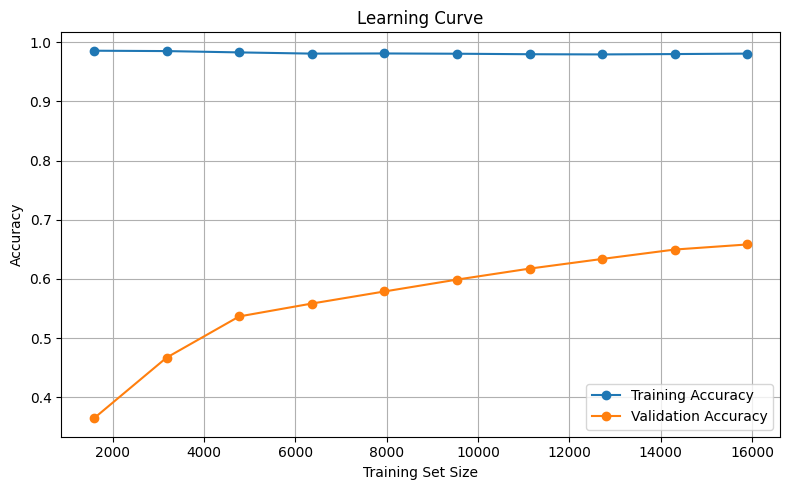

In [34]:
# Part B2 - SVM (TfidfVectorizer)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
}
svc_model = LinearSVC(class_weight='balanced', max_iter=5000)
grid = GridSearchCV(svc_model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(x_train_tfidf, y_train)
svc_best = grid.best_estimator_


#  Evaluations and Plots  
y_pred = svc_best.predict(x_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

train_sizes, train_scores, val_scores = learning_curve(
    svc_best, x_train_tfidf, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Part B1 - Random Forests (untuned) with TfidfVectorizer

# Initialize Random Forest (untuned nonlinear model)
rf = RandomForestClassifier(random_state=42)

# Fit model to training data
rf.fit(x_train_tfidf, y_train)

# Predict on test set
y_pred = rf.predict(x_val_tfidf)
print("Predictions:", y_pred)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Predictions: ['BLOOMBERG' 'KTVU' 'CNNW' ... 'FBC' 'CNBC' 'BBCNEWS']
Validation Accuracy: 0.44488318525830867


In [17]:
correct = np.zeros(31)
sizes = np.zeros(31)
for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    for i in range(len(y_val)):
        if y_val.iloc[i] == channel_name:
            if y_pred[i] == channel_name:
                correct[yi] += 1
            sizes[yi] += 1

for yi in range(31):
    channel_name = encoder.inverse_transform([yi])[0]
    if sizes[yi] > 0:
        accuracy = correct[yi] / sizes[yi]
        print(f"Accuracy for channel '{channel_name}': {accuracy*100:.4f}")
    else:
        print(f"Channel '{channel_name}' has no samples in validation set.")

print(sum(correct) / sum(sizes))


Channel '1TV' has no samples in validation set.
Accuracy for channel 'ALJAZ': 13.7931
Accuracy for channel 'BBCNEWS': 83.7638
Channel 'BELARUSTV' has no samples in validation set.
Accuracy for channel 'BLOOMBERG': 82.9412
Accuracy for channel 'CNBC': 46.0938
Accuracy for channel 'CNNW': 70.3196
Channel 'COM' has no samples in validation set.
Accuracy for channel 'CSPAN': 28.4314
Accuracy for channel 'CSPAN2': 20.6061
Accuracy for channel 'CSPAN3': 2.2599
Accuracy for channel 'DW': 10.8696
Accuracy for channel 'FBC': 52.3364
Accuracy for channel 'FOXNEWSW': 37.2000
Accuracy for channel 'GBN': 57.1429
Accuracy for channel 'KDTV': 90.6250
Accuracy for channel 'KGO': 24.8227
Accuracy for channel 'KNTV': 26.4865
Accuracy for channel 'KPIX': 13.5593
Accuracy for channel 'KQED': 0.0000
Accuracy for channel 'KRON': 43.0464
Accuracy for channel 'KSTS': 77.2727
Accuracy for channel 'KTVU': 42.6087
Channel 'LINKTV' has no samples in validation set.
Accuracy for channel 'MSNBCW': 62.3318
Channel '

In [ ]:
# Part B2 - Random Forests (hyperparameter tuning)
# Resource: https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

# RandomizedSearchCV 
param_dist = {
    'n_estimators': randint(100, 500),          
    'max_depth': randint(10, 100),               
    'min_samples_split': randint(2, 20),        
    'min_samples_leaf': randint(1, 10),         
    'max_features': ['sqrt', 'log2'],         
    'bootstrap': [True, False],               
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                   scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

random_search.fit(x_train_tfidf, y_train)

# Output the best results
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

# Get the best model
best_rf_rand = random_search.best_estimator_
print(best_rf_rand)

# Predictions
y_pred = best_rf_rand.predict(x_val_tfidf)
print("Predictions:", y_pred)

accuracy_rand_search = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy_rand_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   4.8s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   4.2s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   4.0s
[CV] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=  17.0s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   3.9s
[CV] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=  17.6s
[CV] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; 

/Users/larmstrong/Desktop/cs1810practical/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=5, min_samples_split=13, n_estimators=468; total time=  11.2s
[CV] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=5, min_samples_split=13, n_estimators=468; total time=  10.1s
[CV] END bootstrap=True, max_depth=58, max_features=sqrt, min_samples_leaf=4, min_samples_split=19, n_estimators=195; total time=  19.7s
[CV] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=5, min_samples_split=13, n_estimators=468; total time=  10.2s
[CV] END bootstrap=True, max_depth=58, max_features=sqrt, min_samples_leaf=4, min_samples_split=19, n_estimators=195; total time=  19.9s
[CV] END bootstrap=True, max_depth=58, max_features=sqrt, min_samples_leaf=4, min_samples_split=19, n_estimators=195; total time=  19.8s
[CV] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=5, min_samples_split=13, n_estimators=468; total time=   9.1s
[CV] END bootstrap=False, max_depth=3